In [1]:
# Colab Setup
# Colab environment setup

!git clone https://github.com/neurodata/SPORF.git
%cd /content/SPORF/Python
!apt-get update
!apt-get install -y build-essential cmake python3-dev libomp-dev libeigen3-dev  # Ubuntu/Debian
!python setup.py clean --all
!pip install -e .



Cloning into 'SPORF'...
remote: Enumerating objects: 9102, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 9102 (delta 47), reused 93 (delta 32), pack-reused 8974 (from 1)
Receiving objects: 100% (9102/9102), 111.07 MiB | 34.81 MiB/s, done.
Resolving deltas: 100% (5104/5104), done.
/content/SPORF/Python
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 https://cli.github.com/packages stable InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:9 https://ppa.launchpadcontent.net/d

In [2]:
# Imports

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from rerf.RerF import fastPredict, fastPredictPost, fastRerF
from multiprocessing import cpu_count
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Loading dataset

df = pd.read_csv("/content/social_media_vs_productivity.csv")

df.head()



,age,gender,job_type,daily_social_media_time,social_platform_preference,number_of_notifications,work_hours_per_day,perceived_productivity_score,actual_productivity_score,stress_level,sleep_hours,screen_time_before_sleep,breaks_during_work,uses_focus_apps,has_digital_wellbeing_enabled,coffee_consumption_per_day,days_feeling_burnout_per_month,weekly_offline_hours,job_satisfaction_score
0,56,Male,Unemployed,4.180940,Facebook,61,6.753558,8.040464,7.291555,4.0,5.116546,0.419102,8,False,False,4,11,21.927072,6.336688
1,46,Male,Health,3.249603,Twitter,59,9.169296,5.063368,5.165093,7.0,5.103897,0.671519,7,True,True,2,25,0.000000,3.412427
2,32,Male,Finance,NaN,Twitter,57,7.910952,3.861762,3.474053,4.0,8.583222,0.624378,0,True,False,3,17,10.322044,2.474944
3,60,Female,Unemployed,NaN,Facebook,59,6.355027,2.916331,1.774869,6.0,6.052984,1.204540,1,False,False,0,4,23.876616,1.733670
4,25,Male,IT,NaN,Telegram,66,6.214096,8.868753,NaN,7.0,5.405706,1.876254,1,False,True,1,30,10.653519,9.693060


In [4]:
# Preprocessing step: remove or replace NaN values

print(df.isna().sum().sort_values(ascending=False))
print("Orignal Dataset instances: ", len(df))
df.head()

# Drop rows with any NaN value

df_clean = df.dropna().reset_index(drop=True)

print(df_clean.isna().sum().sort_values(ascending=False))
print("After dropping NaNs:", len(df_clean))

daily_social_media_time           2765
job_satisfaction_score            2730
sleep_hours                       2598
actual_productivity_score         2365
screen_time_before_sleep          2211
stress_level                      1904
perceived_productivity_score      1614
job_type                             0
gender                               0
age                                  0
work_hours_per_day                   0
number_of_notifications              0
social_platform_preference           0
uses_focus_apps                      0
breaks_during_work                   0
has_digital_wellbeing_enabled        0
coffee_consumption_per_day           0
days_feeling_burnout_per_month       0
weekly_offline_hours                 0
dtype: int64
Orignal Dataset instances:  30000
age                               0
gender                            0
job_type                          0
daily_social_media_time           0
social_platform_preference        0
number_of_notifications         

In [5]:
# Applying one-hot-encoding to values that are objects and booleans.

df_encoded = pd.get_dummies(df_clean)
df_encoded.head()


print("Orignal df columns: \n", df_clean.columns)
print("Encoded df columns: \n",df_encoded.columns)

Orignal df columns: 
 Index(['age', 'gender', 'job_type', 'daily_social_media_time',
       'social_platform_preference', 'number_of_notifications',
       'work_hours_per_day', 'perceived_productivity_score',
       'actual_productivity_score', 'stress_level', 'sleep_hours',
       'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps',
       'has_digital_wellbeing_enabled', 'coffee_consumption_per_day',
       'days_feeling_burnout_per_month', 'weekly_offline_hours',
       'job_satisfaction_score'],
      dtype='object')
Encoded df columns: 
 Index(['age', 'daily_social_media_time', 'number_of_notifications',
       'work_hours_per_day', 'perceived_productivity_score',
       'actual_productivity_score', 'stress_level', 'sleep_hours',
       'screen_time_before_sleep', 'breaks_during_work', 'uses_focus_apps',
       'has_digital_wellbeing_enabled', 'coffee_consumption_per_day',
       'days_feeling_burnout_per_month', 'weekly_offline_hours',
       'job_satisfaction_sc

In [6]:
# Inspecting dataset after one-hot-encoding:
df_encoded.info()
df_encoded.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17074 entries, 0 to 17073
Data columns (total 30 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   17074 non-null  int64  
 1   daily_social_media_time               17074 non-null  float64
 2   number_of_notifications               17074 non-null  int64  
 3   work_hours_per_day                    17074 non-null  float64
 4   perceived_productivity_score          17074 non-null  float64
 5   actual_productivity_score             17074 non-null  float64
 6   stress_level                          17074 non-null  float64
 7   sleep_hours                           17074 non-null  float64
 8   screen_time_before_sleep              17074 non-null  float64
 9   breaks_during_work                    17074 non-null  int64  
 10  uses_focus_apps                       17074 non-null  bool   
 11  has_digital_wel

,age,daily_social_media_time,number_of_notifications,work_hours_per_day,perceived_productivity_score,actual_productivity_score,stress_level,sleep_hours,screen_time_before_sleep,breaks_during_work,...,job_type_Finance,job_type_Health,job_type_IT,job_type_Student,job_type_Unemployed,social_platform_preference_Facebook,social_platform_preference_Instagram,social_platform_preference_Telegram,social_platform_preference_TikTok,social_platform_preference_Twitter
0,56,4.180940,61,6.753558,8.040464,7.291555,4.0,5.116546,0.419102,8,...,False,False,False,False,True,True,False,False,False,False
1,46,3.249603,59,9.169296,5.063368,5.165093,7.0,5.103897,0.671519,7,...,False,True,False,False,False,False,False,False,False,True
2,56,4.381070,60,3.902309,6.420989,5.976408,7.0,7.549849,2.252624,4,...,False,False,False,False,True,False,False,False,True,False
3,36,4.089168,49,6.560467,2.681830,2.446927,4.0,6.325507,0.747998,2,...,False,False,False,False,False,False,False,False,False,True
4,28,3.341559,57,11.022035,8.940636,7.983252,4.0,3.952547,1.028640,5,...,False,False,True,False,False,False,False,False,False,True


In [7]:
# renaming the cleaned dataset as the og
# Now we have:
# df_encoded: with one-hot-encoding columns for regressions models
# df_og: cleaned dataset for trees

df_og = df_clean


In [8]:

# Unique values for object and boolean datatypes
# To be turned into numeric values for modeling
# Mainly for tree functions, df_encoded for regression models

df_og.info()
df_og_columns = df.columns

for column in df_og_columns:
    if df_og[column].dtype == "object" or df_og[column].dtype == "bool":
        print(df_og[column].unique())

# Convert all unique values to numbers through mapping
for column in df_og_columns:
    if df_og[column].dtype == "object" or df_og[column].dtype == "bool":
        unique_values = df_og[column].unique()
        mapping = {value: i for i, value in enumerate(unique_values)}
        df_og[column] = df_og[column].map(mapping)

# Preview after mapping
df_og.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17074 entries, 0 to 17073
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             17074 non-null  int64  
 1   gender                          17074 non-null  object 
 2   job_type                        17074 non-null  object 
 3   daily_social_media_time         17074 non-null  float64
 4   social_platform_preference      17074 non-null  object 
 5   number_of_notifications         17074 non-null  int64  
 6   work_hours_per_day              17074 non-null  float64
 7   perceived_productivity_score    17074 non-null  float64
 8   actual_productivity_score       17074 non-null  float64
 9   stress_level                    17074 non-null  float64
 10  sleep_hours                     17074 non-null  float64
 11  screen_time_before_sleep        17074 non-null  float64
 12  breaks_during_work              

,age,gender,job_type,daily_social_media_time,social_platform_preference,number_of_notifications,work_hours_per_day,perceived_productivity_score,actual_productivity_score,stress_level,sleep_hours,screen_time_before_sleep,breaks_during_work,uses_focus_apps,has_digital_wellbeing_enabled,coffee_consumption_per_day,days_feeling_burnout_per_month,weekly_offline_hours,job_satisfaction_score
0,56,0,0,4.180940,0,61,6.753558,8.040464,7.291555,4.0,5.116546,0.419102,8,0,0,4,11,21.927072,6.336688
1,46,0,1,3.249603,1,59,9.169296,5.063368,5.165093,7.0,5.103897,0.671519,7,1,1,2,25,0.000000,3.412427
2,56,1,0,4.381070,2,60,3.902309,6.420989,5.976408,7.0,7.549849,2.252624,4,0,0,4,20,24.084905,5.501373
3,36,1,2,4.089168,1,49,6.560467,2.681830,2.446927,4.0,6.325507,0.747998,2,0,0,4,29,8.419648,3.444376
4,28,0,3,3.341559,1,57,11.022035,8.940636,7.983252,4.0,3.952547,1.028640,5,1,1,1,3,13.514515,9.414637


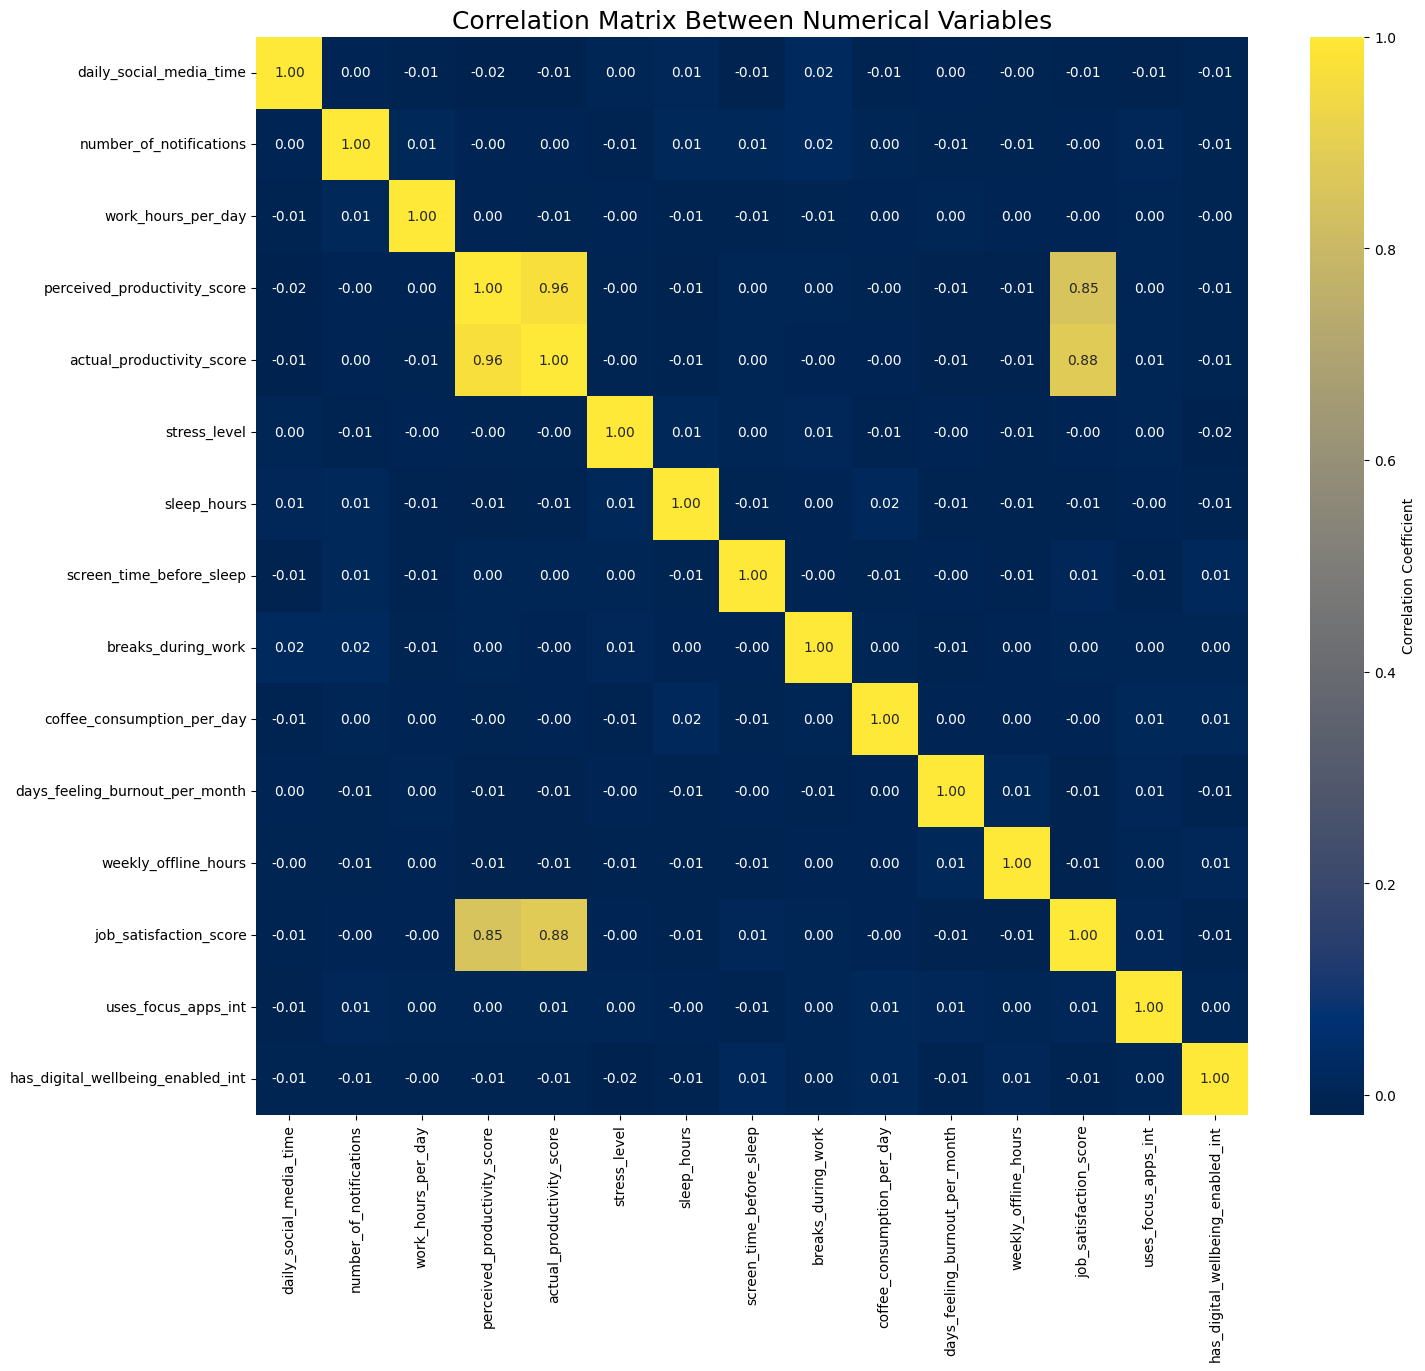

In [9]:
# Correlation between features

# Convert Boolean columns (True/False) to 1/0 before including them in the analysis
df_og['uses_focus_apps_int'] = df_og['uses_focus_apps'].astype(int)
df_og['has_digital_wellbeing_enabled_int'] = df_og['has_digital_wellbeing_enabled'].astype(int)

# All features with numerical values
numerical_cols = [
    'daily_social_media_time', 'number_of_notifications', 'work_hours_per_day',
    'perceived_productivity_score', 'actual_productivity_score', 'stress_level',
    'sleep_hours', 'screen_time_before_sleep', 'breaks_during_work',
    'coffee_consumption_per_day', 'days_feeling_burnout_per_month',
    'weekly_offline_hours', 'job_satisfaction_score',
    'uses_focus_apps_int', 'has_digital_wellbeing_enabled_int'
]

# Corrolation Matrix
corr_matrix = df_og[numerical_cols].corr()

plt.figure(figsize=(16, 14))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='cividis',
    cbar_kws={'label': 'Correlation Coefficient'}
)
plt.title('Correlation Matrix Between Numerical Variables', fontsize=18)
plt.show()

In [10]:

# Part 2: Regression Using SPORF


# features that don't have anything to do with productivity, as well as the output.
output_columns = ['perceived_productivity_score', 'actual_productivity_score']

# Features and labels for clean og dataset without one-hot-encoding
X_og = df_og.drop(columns=output_columns)
Y_og = df_og['actual_productivity_score']

# Features and labels for clean og dataset with one-hot-encoding
X_encoded = df_encoded.drop(columns=output_columns)
Y_encoded = df_encoded['actual_productivity_score']


In [11]:
# Convert to numpy arrays

X_og = X_og.to_numpy()
X_encoded = X_encoded.to_numpy()

Y_og = Y_og.to_numpy()
Y_encoded = Y_encoded.to_numpy()

In [12]:
from sklearn.model_selection import train_test_split

# Desired fractions
test_size = 0.1
val_size = 0.1

# Original dataset splits

X_og_trainval, X_og_test, y_og_trainval, y_og_test = train_test_split(
    X_og, Y_og, test_size=test_size, random_state=42
)

val_fraction = val_size / (1 - test_size)

X_og_train, X_og_val, y_og_train, y_og_val = train_test_split(
    X_og_trainval, y_og_trainval, test_size=val_fraction, random_state=42
)


# One-hot encoded dataset splits

X_enc_trainval, X_enc_test, y_enc_trainval, y_enc_test = train_test_split(
    X_encoded, Y_encoded, test_size=test_size, random_state=42
)

val_fraction = val_size / (1 - test_size)

X_enc_train, X_enc_val, y_enc_train, y_enc_val = train_test_split(
    X_enc_trainval, y_enc_trainval, test_size=val_fraction, random_state=42
)


In [13]:
# %% Check shapes for original dataset
print("Original dataset shapes:")
print(f"X_og_train shape: {X_og_train.shape}")
print(f"X_og_val shape:   {X_og_val.shape}")
print(f"X_og_test shape:  {X_og_test.shape}")
print(f"y_og_train shape: {y_og_train.shape}")
print(f"y_og_val shape:   {y_og_val.shape}")
print(f"y_og_test shape:  {y_og_test.shape}\n")

# %% Check shapes for one-hot encoded dataset
print("One-hot encoded dataset shapes:")
print(f"X_enc_train shape: {X_enc_train.shape}")
print(f"X_enc_val shape:   {X_enc_val.shape}")
print(f"X_enc_test shape:  {X_enc_test.shape}")
print(f"y_enc_train shape: {y_enc_train.shape}")
print(f"y_enc_val shape:   {y_enc_val.shape}")
print(f"y_enc_test shape:  {y_enc_test.shape}")


Original dataset shapes:
X_og_train shape: (13658, 19)
X_og_val shape:   (1708, 19)
X_og_test shape:  (1708, 19)
y_og_train shape: (13658,)
y_og_val shape:   (1708,)
y_og_test shape:  (1708,)

One-hot encoded dataset shapes:
X_enc_train shape: (13658, 28)
X_enc_val shape:   (1708, 28)
X_enc_test shape:  (1708, 28)
y_enc_train shape: (13658,)
y_enc_val shape:   (1708,)
y_enc_test shape:  (1708,)


In [14]:
# %%
# Train Randomer Forest
forest = fastRerF(
    X=X_og_train,
    Y=y_og_train,
    forestType="rfBase",  # regression forest
    trees=500,
    maxDepth=20,
    minParent=5,
    numCores=cpu_count()
)

forest.printParameters()


numTreesInForest -> 500
maxDepth -> 20
minParent -> 5
numClasses -> 10
numObservations -> 13658
numFeatures -> 19
mtry -> 4
mtryMult -> 1.5
fractionOfFeaturesToTest -> -1
CSV file name -> 
columnWithY -> -1
Type of Forest -> rfBase
binSize -> 0
binMin -> 0
numCores -> 2
seed -> 921102
numTreeBins -> -1


In [15]:
# Training errors:

train_pred = fastPredict(X_og_train, forest)

# Compute errors
train_rmse = mean_squared_error(y_og_train, train_pred)  # RMSE
train_mae = mean_absolute_error(y_og_train, train_pred)

# Convert to percentage of mean
mean_target = Y_og.mean()
train_rmse_percent = (train_rmse / mean_target) * 100
train_mae_percent = (train_mae / mean_target) * 100

print("Train RMSE (% of mean):", train_rmse_percent, "%")
print("Train MAE (% of mean):", train_mae_percent, "%")


Train RMSE (% of mean): 6.975082929857604 %
Train MAE (% of mean): 10.20111960344286 %


In [16]:
# Validation Errors:

# Make predictions on the validation set
val_pred = fastPredict(X_og_val, forest)

# Compute error metrics
val_rmse = mean_squared_error(y_og_val, val_pred)
val_mae = mean_absolute_error(y_og_val, val_pred)

# Optionally, convert to % of mean
val_rmse_percent = (val_rmse / Y_og.mean()) * 100
val_mae_percent = (val_mae / Y_og.mean()) * 100

print("Validation RMSE:", val_rmse)
print("Validation RMSE (% of mean):", val_rmse_percent)
print("Validation MAE:", val_mae)
print("Validation MAE (% of mean):", val_mae_percent)


Validation RMSE: 1.1975849887543775
Validation RMSE (% of mean): 24.22040192897008
Validation MAE: 0.8815835657812868
Validation MAE (% of mean): 17.82947222760883


In [21]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from multiprocessing import cpu_count
import numpy as np

# --- Parameters ---
k = 5
n_trees = 100       # reduced number of trees for CV
max_depth = 20
min_parent = 5
batch_size = 100    # small batch for safe prediction

# --- Arrays to store metrics ---
rmse_list = []
mae_list = []
rmse_percent_list = []
mae_percent_list = []

# --- Safe batch prediction function ---
def safe_batch_predict(forest, X, batch_size=100):
    preds = []
    for i in range(0, len(X), batch_size):
        X_batch = X[i:i+batch_size]
        preds_batch = fastPredict(X_batch, forest)
        preds.append(preds_batch)
    return np.concatenate(preds)

# --- KFold cross-validation ---
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_og), 1):
    X_train_cv, X_val_cv = X_og[train_idx], X_og[val_idx]
    y_train_cv, y_val_cv = Y_og[train_idx], Y_og[val_idx]

    print(f"Fold {fold}: Training size = {len(X_train_cv)}, Validation size = {len(X_val_cv)}")

    # Train RerF with fewer trees
    forest_cv = fastRerF(
        X=X_train_cv,
        Y=y_train_cv,
        forestType="rfBase",
        trees=n_trees,
        maxDepth=max_depth,
        minParent=min_parent,
        numCores=cpu_count()
    )

    # Batch prediction on validation fold
    val_pred = safe_batch_predict(forest_cv, X_val_cv, batch_size=batch_size)

    # Compute metrics
    rmse = mean_squared_error(y_val_cv, val_pred)
    mae = mean_absolute_error(y_val_cv, val_pred)

    rmse_percent = (rmse / Y_og.mean()) * 100
    mae_percent = (mae / Y_og.mean()) * 100

    # Store metrics
    rmse_list.append(rmse)
    mae_list.append(mae)
    rmse_percent_list.append(rmse_percent)
    mae_percent_list.append(mae_percent)

# --- Average metrics across folds ---
print("\n5-Fold Cross-Validation Results:")
print(f"RMSE: {np.mean(rmse_list):.3f} ± {np.std(rmse_list):.3f}")
print(f"RMSE (% of mean): {np.mean(rmse_percent_list):.2f}% ± {np.std(rmse_percent_list):.2f}%")
print(f"MAE: {np.mean(mae_list):.3f} ± {np.std(mae_list):.3f}")
print(f"MAE (% of mean): {np.mean(mae_percent_list):.2f}% ± {np.std(mae_percent_list):.2f}%")


Fold 1: Training size = 13659, Validation size = 3415


ValueError: cannot create std::vector larger than max_size()